# LLaVA

## Simple Inference

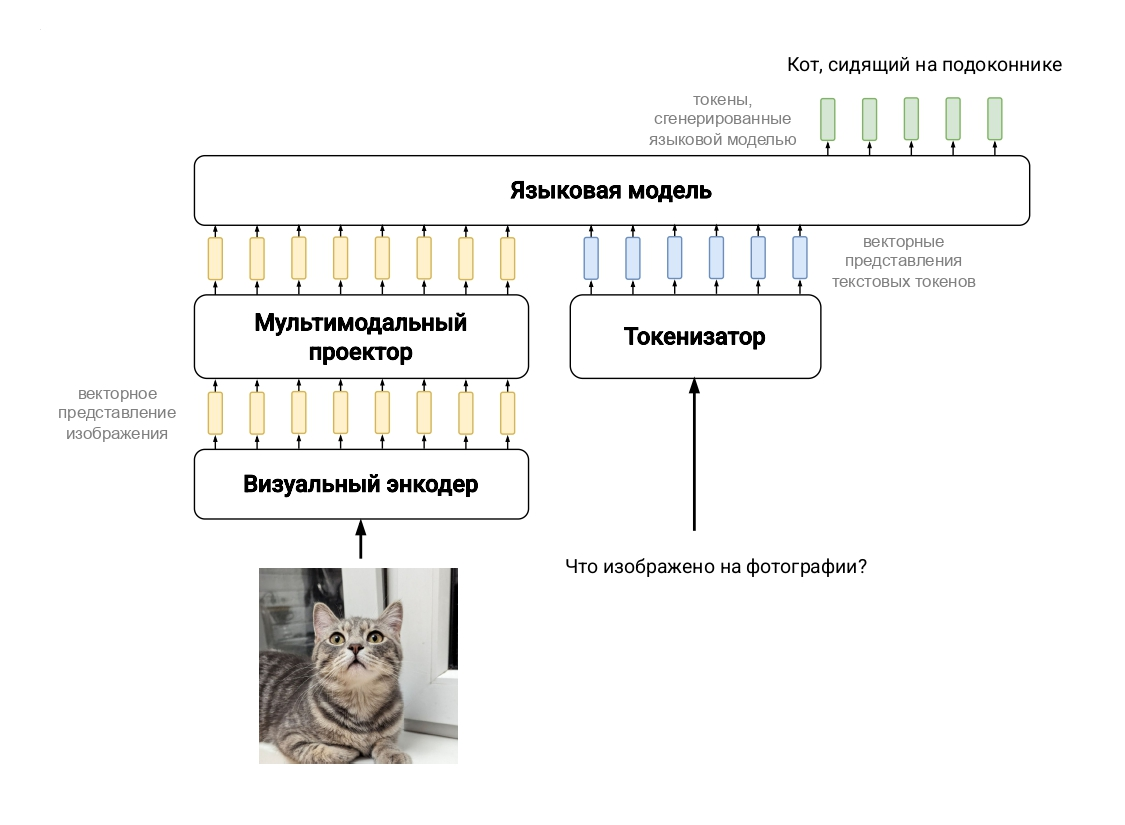

https://huggingface.co/lmms-lab/llava-onevision-qwen2-7b-ov

Есть версия с LLM на 0.5B параметров: https://huggingface.co/lmms-lab/llava-onevision-qwen2-0.5b-ov

In [ ]:
!pip install -q git+https://github.com/LLaVA-VL/LLaVA-NeXT.git
!pip install -q bitsandbytes

In [4]:
from llava.model.builder import load_pretrained_model
import warnings

warnings.filterwarnings("ignore")
pretrained = "lmms-lab/llava-onevision-qwen2-7b-ov"
model_name = "llava_qwen"
device = "cuda"
tokenizer, model, image_processor, _ = load_pretrained_model(pretrained, None, model_name, device_map=device, load_8bit=True, attn_implementation=None)

_ = model.eval()
_ = model.requires_grad_(False)

/opt/python/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/opt/python/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loaded LLaVA model: lmms-lab/llava-onevision-qwen2-7b-ov


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
You are using a model of type llava to instantiate a model of type llava_qwen. This is not supported for all configurations of models and can yield errors.


Loading vision tower: google/siglip-so400m-patch14-384


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json: 0.00B [00:00, ?B/s]

Model Class: LlavaQwenForCausalLM


In [5]:
model

LlavaQwenForCausalLM(
  (model): LlavaQwenModel(
    (embed_tokens): Embedding(151647, 3584)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear8bitLt(in_features=3584, out_features=3584, bias=True)
          (k_proj): Linear8bitLt(in_features=3584, out_features=512, bias=True)
          (v_proj): Linear8bitLt(in_features=3584, out_features=512, bias=True)
          (o_proj): Linear8bitLt(in_features=3584, out_features=3584, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear8bitLt(in_features=3584, out_features=18944, bias=False)
          (up_proj): Linear8bitLt(in_features=3584, out_features=18944, bias=False)
          (down_proj): Linear8bitLt(in_features=18944, out_features=3584, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMS

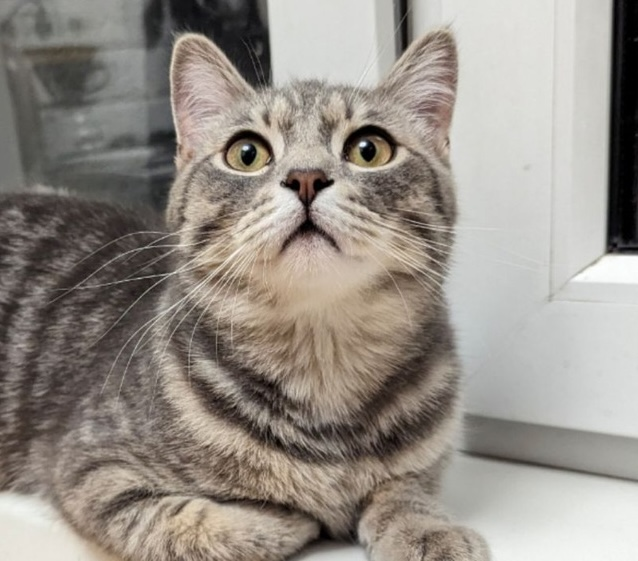

In [6]:
from IPython import display

image_path = 'images/cat.jpg'

display.display(display.Image(filename=image_path, width=200))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch


# вспомогательная функция для рисования картинок
def plot_images(images):
    num_images = len(images)

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))

    if num_images == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        img = images[i].cpu()  # shape [C, H, W]
        img = img.permute(1, 2, 0)  # to [H, W, C]
        img = img.numpy().astype(np.float32)

        # ax.imshow(img)
        # print(img)
        ax.imshow((img - img.min()) / (img.max() - img.min()))  # normalize for display
        ax.axis("off")

    plt.show()

In [8]:
from PIL import Image


image = Image.open(image_path)
print(f'Исходное разрешение изображения: {image.size[0]}x{image.size[1]}')
print(f'Входное разрешение энкодера: {image_processor.crop_size["width"]}x{image_processor.crop_size["height"]}')

Исходное разрешение изображения: 638x561
Входное разрешение энкодера: 384x384


In [9]:
# 1. prepare the image for encoding
from llava.mm_utils import expand2square


def simple_process_image(image, image_processor):
    image = expand2square(image, tuple(int(x * 255) for x in image_processor.image_mean))
    image = image_processor.preprocess(image, return_tensors="pt")["pixel_values"][0]

    return image

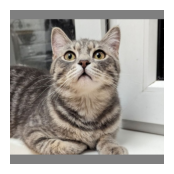

Полученное разрешение: 384x384


In [10]:
processed_image = simple_process_image(image, image_processor=image_processor)
plot_images([processed_image])
print(f'Полученное разрешение: {processed_image.shape[1]}x{processed_image.shape[2]}')

In [11]:
processed_image.shape

torch.Size([3, 384, 384])

In [ ]:
# 2. pass the image to the encoder

# llava.model.multimodal_encoder.siglip_encoder.SigLipVisionTower
class SigLipVisionTower:
    def forward(self, images):
        image_forward_outs = self.vision_tower(images.to(device=self.device, dtype=self.dtype), output_hidden_states=True)
        image_features = image_forward_outs.hidden_states[-1].to(images.dtype)
        assert image_features.shape[-2] == 729

        return image_features

In [13]:
vision_encoder = model.get_vision_tower()
# output = SigLipVisionTower.forward(vision_encoder, processed_image[None, :])

# input: (num_images, C, W, H)
image_features = vision_encoder(processed_image[None, :])
print(f'{image_features.shape=}')

image_features.shape=torch.Size([1, 729, 1152])


In [14]:
27 * 27

729

In [15]:
# 3. project visual features to LLM input
multimodal_projector = model.get_model().mm_projector
multimodal_projector

Sequential(
  (0): Linear8bitLt(in_features=1152, out_features=3584, bias=True)
  (1): GELU(approximate='none')
  (2): Linear8bitLt(in_features=3584, out_features=3584, bias=True)
)

In [16]:
image_features = multimodal_projector(image_features)
print(f'{image_features.shape=}')

image_features.shape=torch.Size([1, 729, 3584])


In [303]:
# 4. prepare input tokens
# from llava.constants import DEFAULT_IMAGE_TOKEN

DEFAULT_IMAGE_TOKEN = "<image>"

text_prompt = f'{DEFAULT_IMAGE_TOKEN}\nWhat is shown in the image?'


def format_prompt(prompt, tokenizer):
    conv = [
        {
            "role": "user",
            "content": prompt,
        },
    ]

    return tokenizer.apply_chat_template(conv, tokenize=False)

prompt = format_prompt(text_prompt, tokenizer)
prompt

'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<image>\nWhat is shown in the image?<|im_end|>\n'

In [18]:
tokenizer.encode('<image>')

[151646]

In [19]:
tokenized_prompt = tokenizer.encode(prompt)
tokenized_prompt

[151644,
 8948,
 198,
 2610,
 525,
 264,
 10950,
 17847,
 13,
 151645,
 198,
 151644,
 872,
 198,
 151646,
 198,
 3838,
 374,
 6839,
 304,
 279,
 2168,
 30,
 151645,
 198]

In [ ]:
import re


def get_prompt_embeds(model, prompt, images, tokenizer) -> torch.Tensor:
    """
    :param images: (num_images, num_embeds, hidden_dim)

    :returns: (num_tokens, hidden_dim)
    """
    assert len(re.findall('<image>', prompt)) == len(images), 'The number of images is not equal to the number of image tokens'

    image_token_index = tokenizer.encode('<image>')[0]
    tokenized_prompt = tokenizer.encode(prompt)

    text_chunks = []  # между ними вставим визуальные эмбеддинги
    prev_i = 0
    for i in range(len(tokenized_prompt) + 1):
        if i == len(tokenized_prompt) or tokenized_prompt[i] == image_token_index:
            text_chunks.append(tokenized_prompt[prev_i:i])
            prev_i = i + 1

    text_embeds = [model.get_model().embed_tokens(torch.tensor(text_chunk)) for text_chunk in text_chunks]

    result_embeds = []
    for text_chunk_embeds, image_features in zip(text_embeds, images):
        assert image_features.shape[-1] == model.get_model().embed_tokens.embedding_dim, 'Visual features dimension differs from the text embeds dimension'
        result_embeds += [text_chunk_embeds, image_features]
    result_embeds.append(text_embeds[-1])
    return torch.concat(result_embeds, dim=0)

In [23]:
prompt_embeds = get_prompt_embeds(model, prompt, image_features, tokenizer)
print(f'{prompt_embeds.shape=}')

prompt_embeds.shape=torch.Size([753, 3584])


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


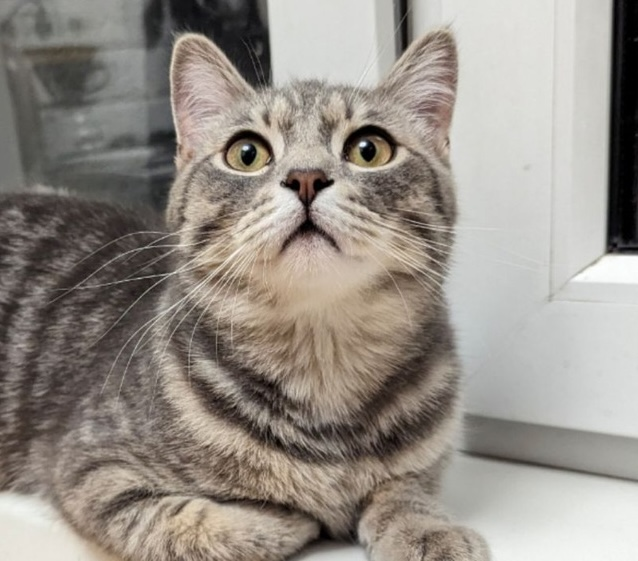

<|im_start|>assistant
The image shows a cat with a grey and white coat. The cat has striking green eyes and appears to be looking upwards, possibly at something that has caught its attention. The background is minimal, featuring what looks like a window frame,


In [25]:
# 5. pass to LLM
from transformers import Qwen2ForCausalLM


generated_tokens = Qwen2ForCausalLM.generate(model, inputs_embeds=prompt_embeds[None, :].to(model.dtype), max_new_tokens=50, do_sample=False)[0]
display.display(display.Image(filename=image_path, width=200))
print(tokenizer.decode(generated_tokens))

## AnyRes

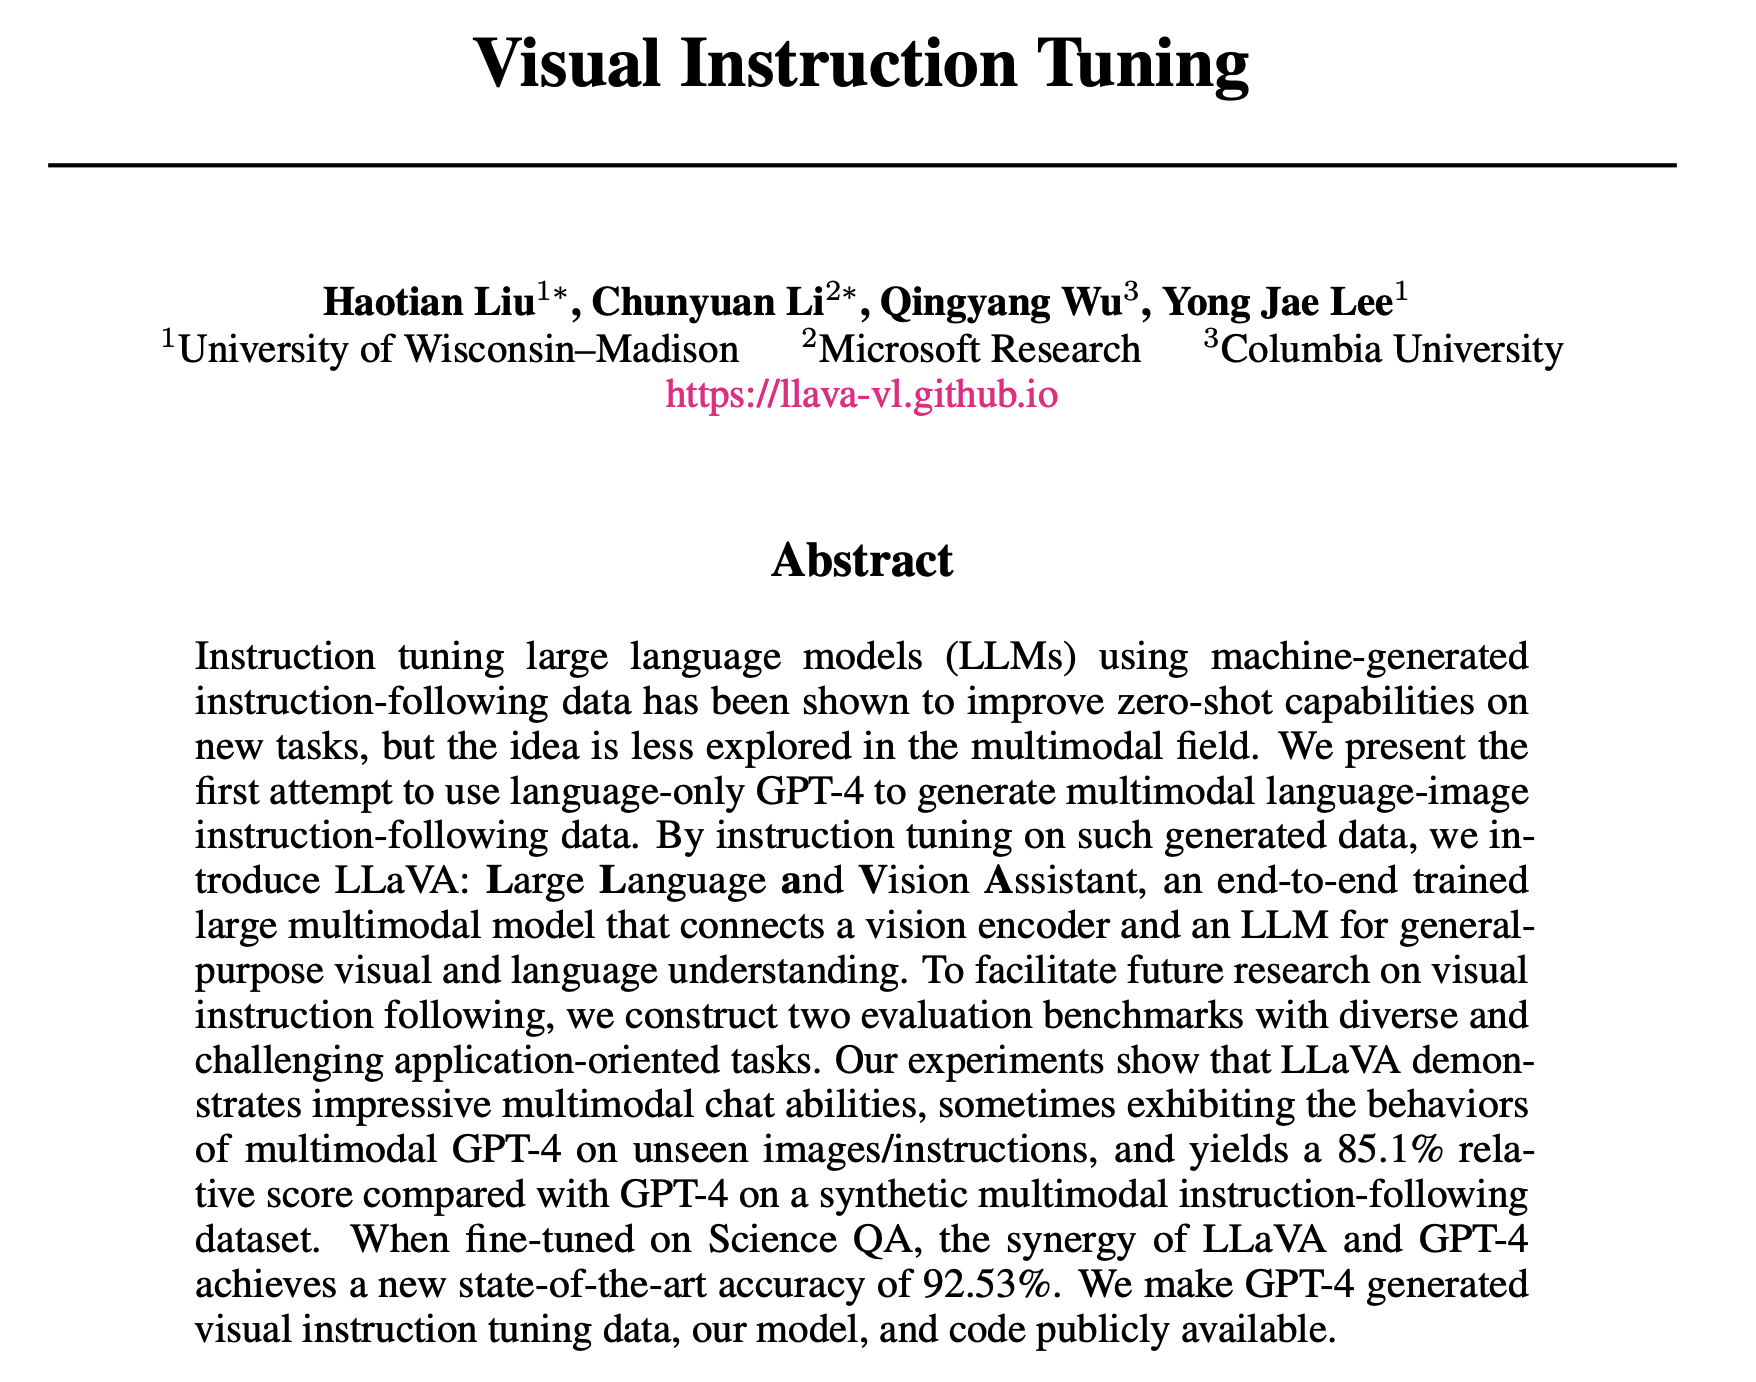

Исходное разрешение изображения: 1756x1382


In [308]:
image_path = 'images/llava_abstract.png'
display.display(display.Image(filename=image_path, width=500))

image = Image.open(image_path)
print(f'Исходное разрешение изображения: {image.size[0]}x{image.size[1]}')

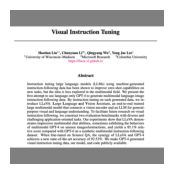

In [309]:
processed_image = simple_process_image(image, image_processor=image_processor)
plot_images([processed_image])

In [ ]:
from llava.mm_utils import (
    select_best_resolution,
    resize_and_pad_image,
    divide_to_patches,
)


# llava.mm_utils.process_anyres_image
def split_image_into_anyres_patches(image, processor, grid_pinpoints) -> torch.Tensor:
    # ... поддержка разных форматов ввода grid_pinpoints ...
    possible_resolutions = grid_pinpoints

    best_resolution = select_best_resolution(image.size, possible_resolutions)
    image_padded = resize_and_pad_image(image, (best_resolution[0] * processor.size[0], best_resolution[1] * processor.size[1]))

    patches = divide_to_patches(image_padded, processor.crop_size["height"])

    shortest_edge = min(processor.size)
    image_original_resize = image.resize((shortest_edge, shortest_edge))

    image_patches = [image_original_resize] + patches
    image_patches = [processor.preprocess(image_patch, return_tensors="pt")["pixel_values"][0] for image_patch in image_patches]
    return torch.stack(image_patches, dim=0), best_resolution

WxH = 1x1


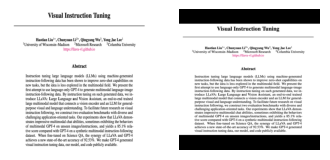

WxH = 2x2


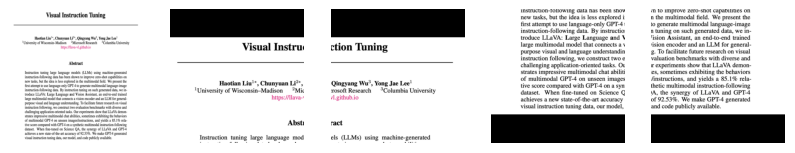

WxH = 3x3


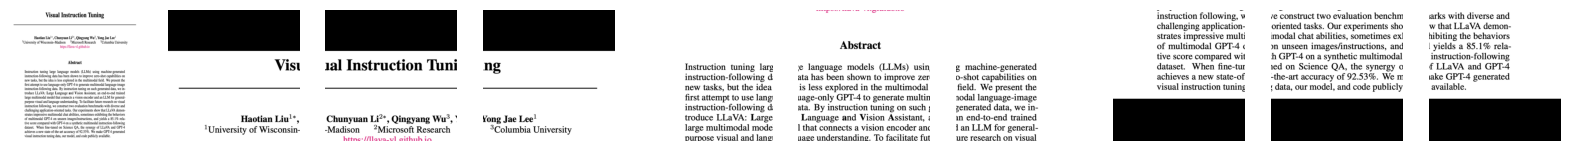

best WxH = 3x3


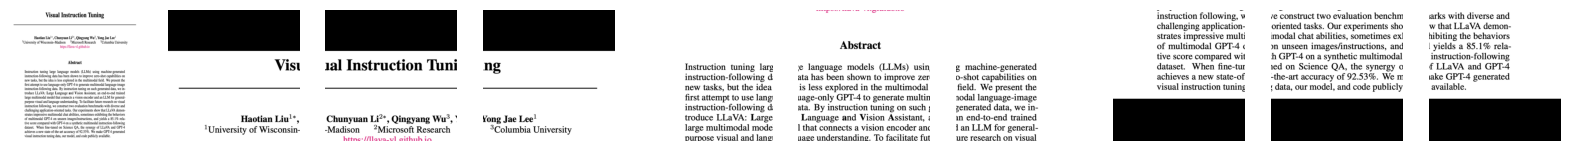

In [311]:
patch_size = image_processor.size[0]

for i in range(1, 4):
    patches, _ = split_image_into_anyres_patches(image, image_processor, grid_pinpoints=[[i, i]])
    print(f'WxH = {i}x{i}')
    plot_images(patches)


grid_pinpoints = []
num_max_patches = 9
for i in range(1, num_max_patches + 1):
    for j in range(1, num_max_patches // i + 1):
        grid_pinpoints.append([i, j])

patches, anyres_res = split_image_into_anyres_patches(image, image_processor, grid_pinpoints=grid_pinpoints)
print(f'best WxH = {anyres_res[0]}x{anyres_res[1]}')
plot_images(patches)

In [ ]:
from llava.model.llava_arch import unpad_image


def encode_images(images, model):
    """
    :param image: (B, C, W, H) already preprocessed

    :returns: (B, num_embeds, embed_dim)
    """
    vision_tower = model.get_vision_tower()
    mm_projector = model.get_model().mm_projector

    image_features = vision_tower(images)
    image_features = mm_projector(image_features)

    return image_features


def reorder_embeds(patch_embeds, model, anyres_grid, orig_image_size, order_type='spatial_unpad', add_newline_token: bool = True):
    if order_type not in ['spatial', 'spatial_unpad']:
        raise NotImplementedError

    thumbnail_embeds = patch_embeds[0]  # (num_embeds, embed_dim)
    patch_embeds = patch_embeds[1:]  # (num_patches, num_embeds, embed_dim)

    vision_encoder_config = model.get_vision_tower().config
    vit_height = vit_width = vision_encoder_config.image_size // vision_encoder_config.patch_size  # how many ViT-patches are in height and width of one image
    anyres_width, anyres_height = anyres_grid

    # ----
    # (num_patches, num_embeds, embed_dim) -> (anyres-height, anyres-width, vit-height, vit-width, embed_dim)
    image_features = patch_embeds.view(anyres_height, anyres_width, vit_height, vit_width, -1)  # (anyres-height, anyres-width, vit-height, vit-width, embed_dim)
    image_features = image_features.permute(4, 0, 2, 1, 3).contiguous()  # (embed_dim, anyres-height, vit-height, anyres-width, vit-width)
    image_features = image_features.flatten(1, 2).flatten(2, 3)  # (embed_dim, all-vit-height, all-vit-width)

    if 'unpad' in order_type:
        print(f'Anyres-patches embeds before unpad: {image_features.shape[1] * image_features.shape[2]} ViT embeds')
        image_features = unpad_image(image_features, orig_image_size)  # (embed_dim, height, width): either height or width reduced
        print(f'Anyres-patches embeds after unpad: {image_features.shape[1] * image_features.shape[2]} ViT embeds')

        if add_newline_token:
            newline_embed = model.get_model().image_newline  # (embed_dim,)
            newline_embed = newline_embed[:image_features.shape[0]]  # for test purposes
            image_features = torch.cat((image_features, newline_embed[:, None, None].expand(*image_features.shape[:-1], 1).to(image_features.device)), dim=-1)  # (embed_dim, height, width + 1)

    image_features = image_features.flatten(1, 2).transpose(0, 1)  # (all-vit-patches left-to-right up-to-bottom, embed_dim)

    return torch.cat((thumbnail_embeds, image_features), dim=0)


def dummy_encode(images, model):
    """
    :param image: (B, C, W, H) already preprocessed
    """
    vision_encoder_config = model.get_vision_tower().config
    patch_size = vision_encoder_config.patch_size
    vit_height = vit_width = vision_encoder_config.image_size // patch_size

    images = images[:, :, :patch_size*vit_width, :patch_size*vit_height]  # (B, C, W, H)
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)  # (B, C, vit_height, vit_width, patch_height, patch_width)
    patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous()  # (B, vit_height, vit_width, C, patch_height, patch_width)
    patches = patches.flatten(1, 2).flatten(-3, -1)  # (B, vit, embed_dim)
    return patches  # (B, vit, embed_dim)

Anyres-patches embeds before unpad: 2916 ViT embeds
Anyres-patches embeds after unpad: 2268 ViT embeds


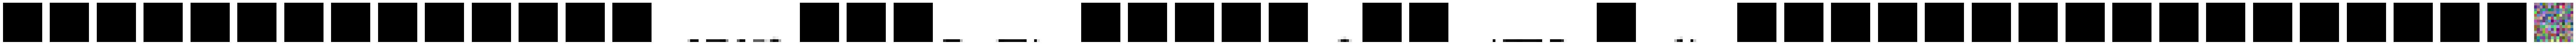

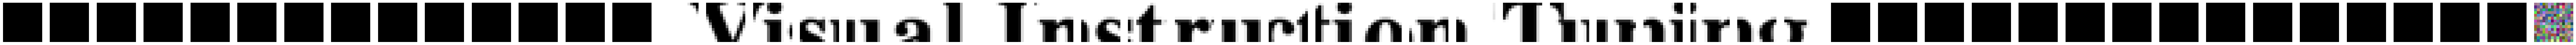

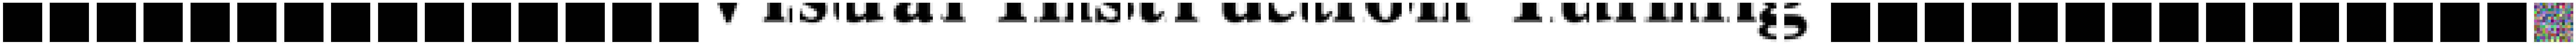

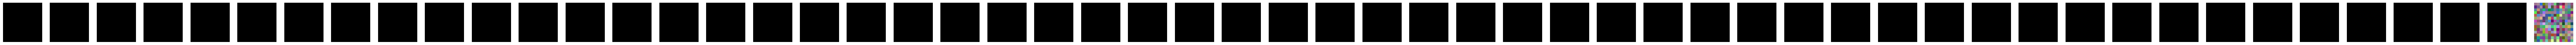

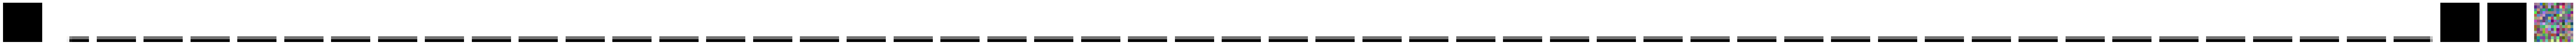

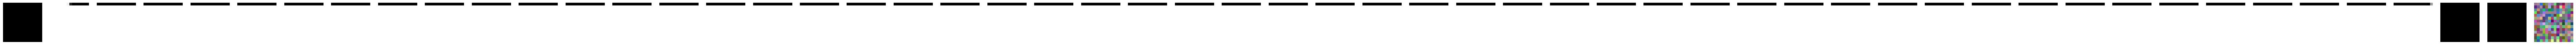

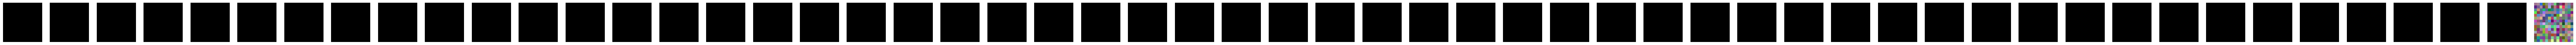

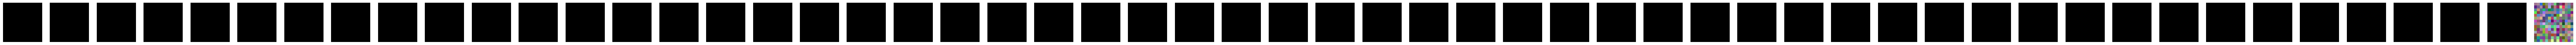

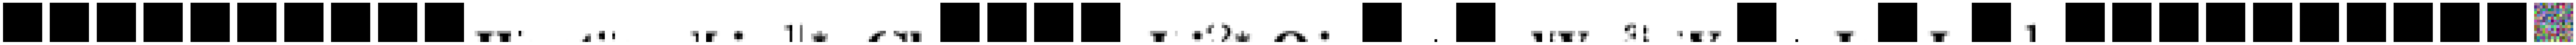

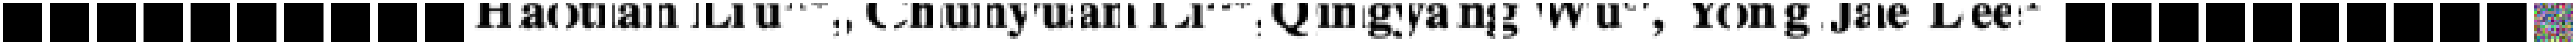

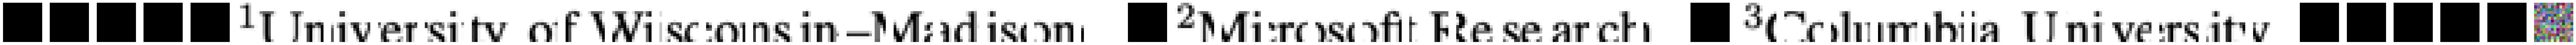

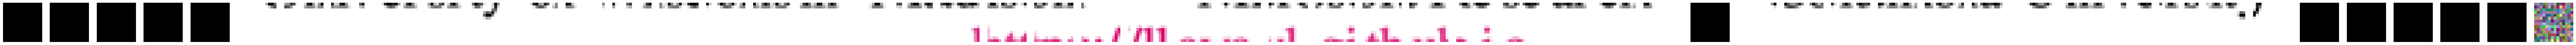

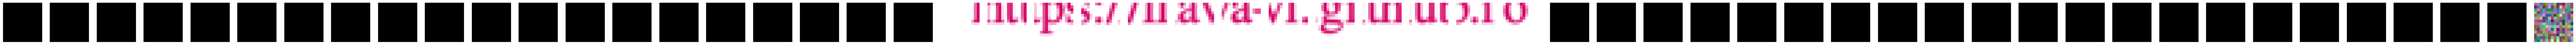

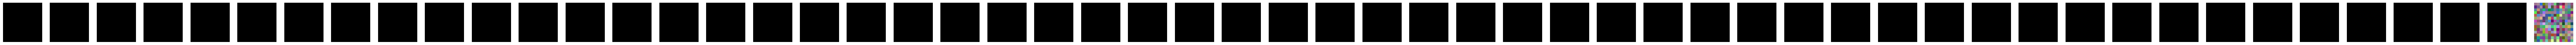

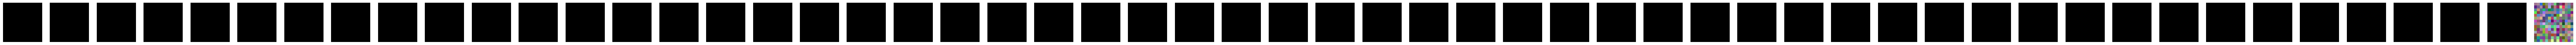

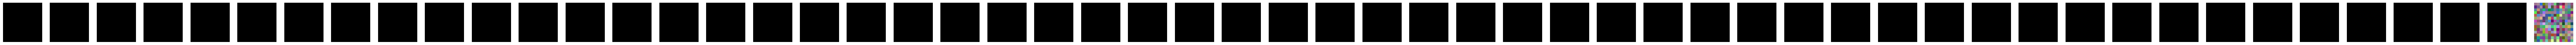

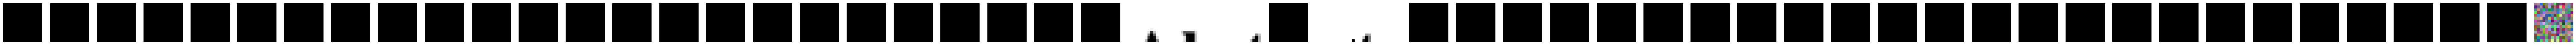

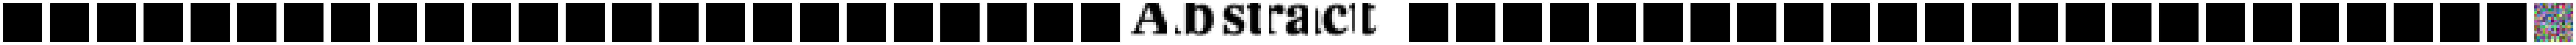

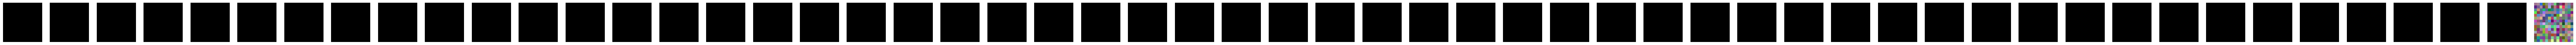

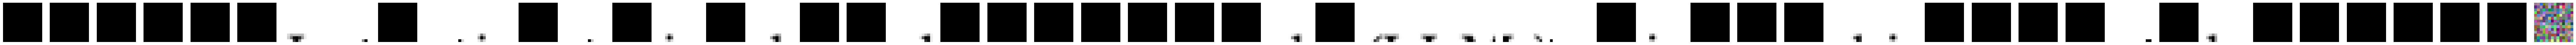

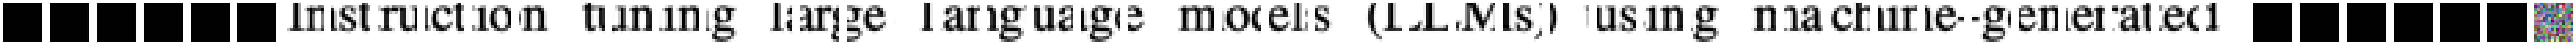

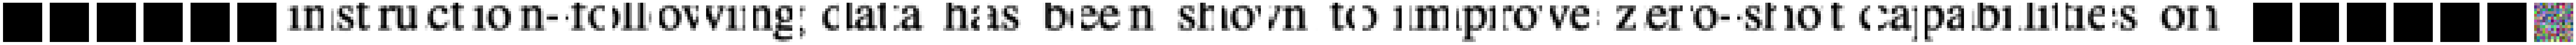

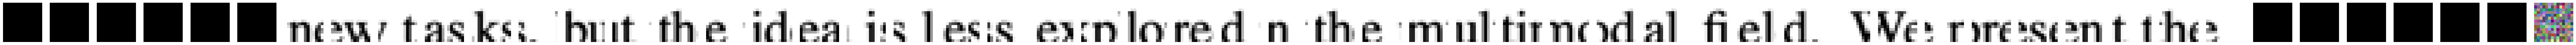

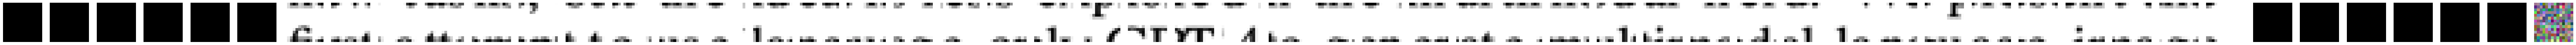

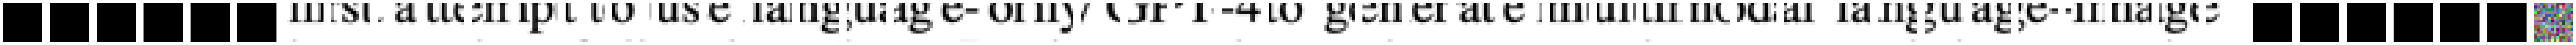

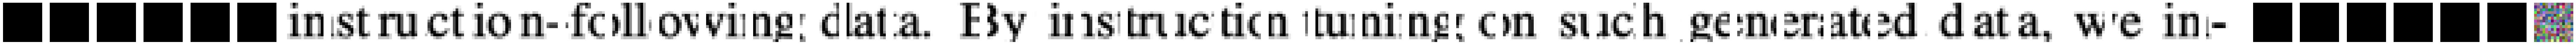

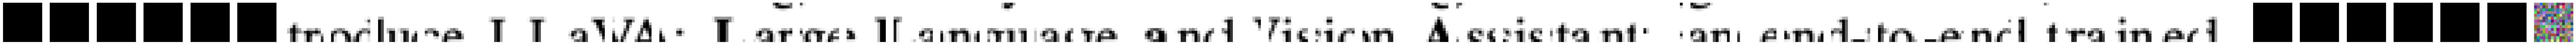

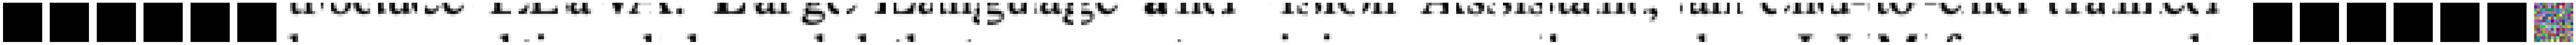

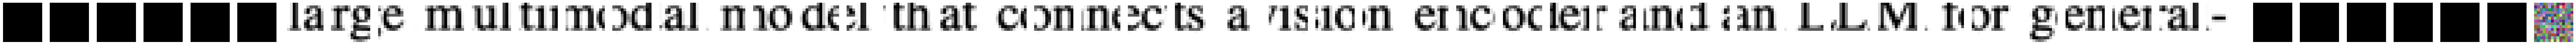

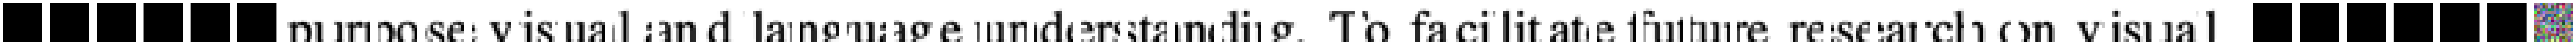

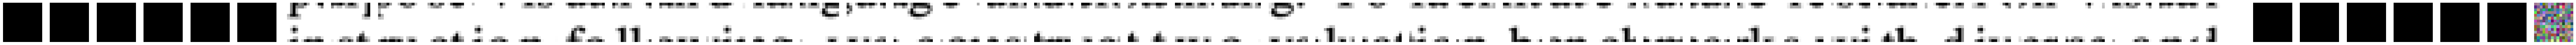

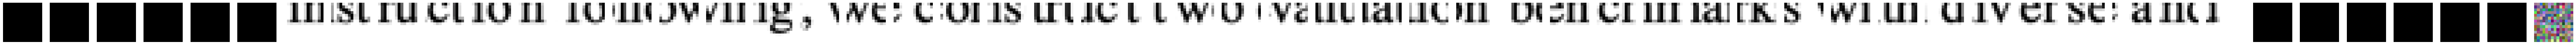

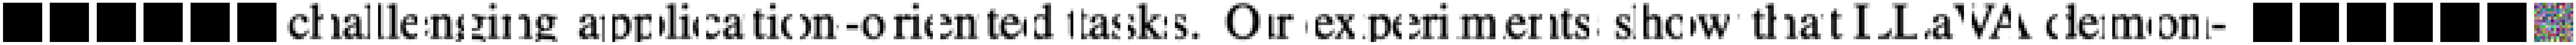

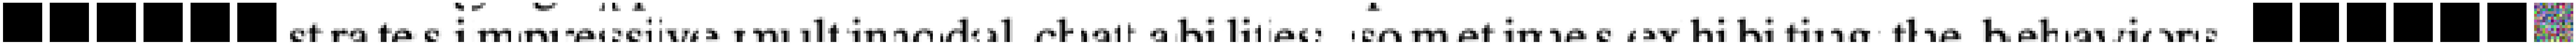

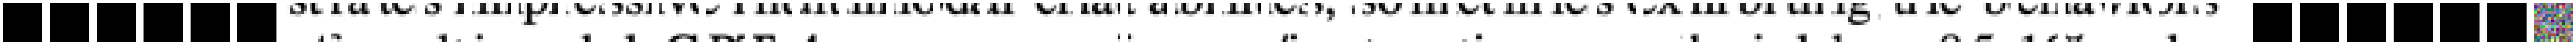

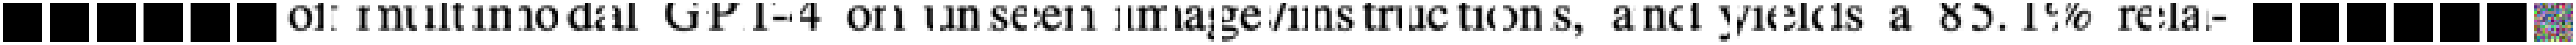

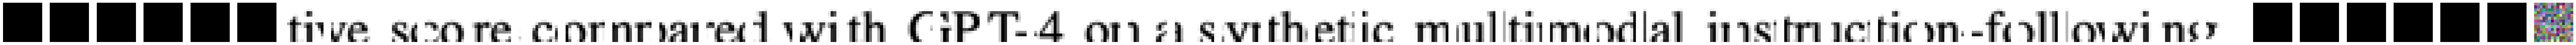

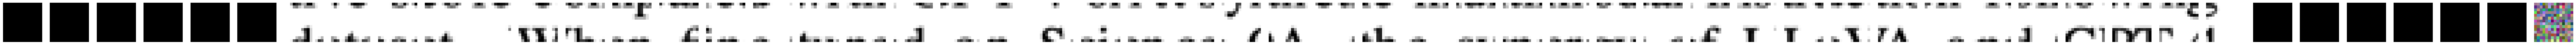

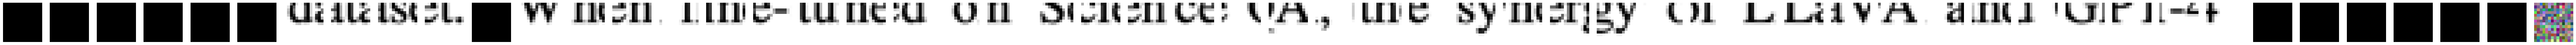

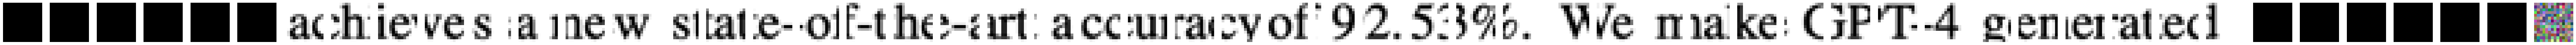

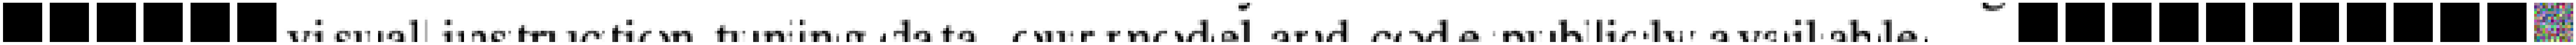

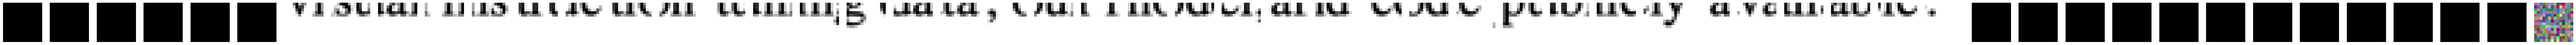

In [322]:
import math

# проверяем порядок
patches, _ = split_image_into_anyres_patches(image, image_processor, grid_pinpoints=[[2, 2]])

test_patch_size = 14
vit_dim = model.get_vision_tower().config.image_size // test_patch_size

dummy_embeds = dummy_encode(patches, model)
reordered_dummy_embeds = reorder_embeds(dummy_embeds, model, anyres_grid=(2, 2), orig_image_size=image.size, order_type='spatial_unpad', add_newline_token=True)  # (num_embeds, C*patch_height*patch_width)

reordered_dummy_embeds_patches = reordered_dummy_embeds[vit_dim*vit_dim:]
reordered_dummy_embeds_patches = reordered_dummy_embeds_patches.view(-1, 3, test_patch_size, test_patch_size)

max_per_row = 2*27 + 1
for i in range(math.ceil(reordered_dummy_embeds_patches.shape[0] / max_per_row)):
    imgs = [reordered_dummy_embeds_patches[j, :] for j in range(i*max_per_row, (i+1)*max_per_row)]
    plot_images(imgs)

In [ ]:
import time


def gen_response_anyres(prompt, image, model, image_processor, tokenizer, grid_pinpoints, **gen_kwargs):
    anyres_patches, anyres_grid = split_image_into_anyres_patches(image, image_processor, grid_pinpoints)
    # anyres_patches: (num_patches, C, H, W)
    print(f'chosen AnyRes WxH = {anyres_grid[0]}x{anyres_grid[1]}')
    plot_images(anyres_patches)

    image_embeds = encode_images(anyres_patches, model)  # (num_embeds', embed_dim)
    image_embeds = reorder_embeds(image_embeds, model, anyres_grid=anyres_grid, orig_image_size=image.size)  # (num_embeds, embed_dim)
    print(f'#visual tokens: {len(image_embeds)}')

    prompt = format_prompt(prompt, tokenizer)
    prompt_embeds = get_prompt_embeds(model, prompt, image_embeds[None, :], tokenizer)  # (all num_embeds, embed_dim)
    print(f'#text tokens: {len(prompt_embeds) - len(image_embeds)}')

    st_time = time.time()
    cont_tokens = Qwen2ForCausalLM.generate(model, inputs_embeds=prompt_embeds[None, :].to(model.dtype), **gen_kwargs)[0]
    end_time = time.time()

    print(f'Generation time: {(end_time - st_time):.1f} seconds')

    return tokenizer.decode(cont_tokens)

**Question**: <image>
What is written in the image?
chosen AnyRes WxH = 1x1


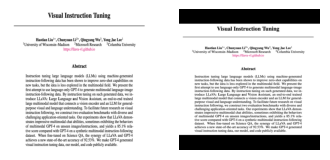

Anyres-patches embeds before unpad: 729 ViT embeds
Anyres-patches embeds after unpad: 567 ViT embeds
#visual tokens: 1317
#text tokens: 24
Generation time: 20.4 seconds

**Response**: <|im_start|>assistant
The image contains a document with text, which appears to be an academic paper or article. The title at the top reads "Visual Instruction Tuning." Below the title, there are names listed, which are likely the authors of the paper. The abstract section provides a brief summary of the content, discussing the tuning of large language models using machine-generated instructions and the potential for improving zero-shot capabilities on new tasks. It mentions the use of a specific model called LLaMA and discusses the results of experiments that demonstrate the effectiveness of this approach. The text is too small to read in detail, but it seems to be a technical discussion related to artificial intelligence and natural language processing.<|im_end|>


chosen AnyRes WxH = 2x2


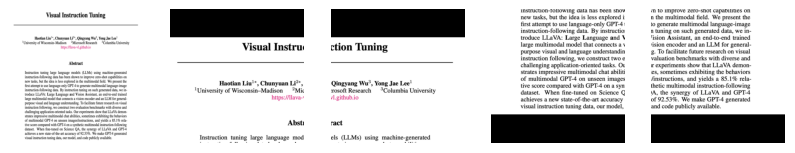

Anyres-patches embeds before unpad: 2916 ViT embeds
Anyres-patches embeds after unpad: 2268 ViT embeds
#visual tokens: 3039
#text tokens: 24
Generation time: 41.4 seconds

**Response**: <|im_start|>assistant
The image contains a document with text that appears to be an abstract from a research paper or academic article. The title of the document is "Visual Instruction Tuning." Below the title, there are names and affiliations of authors associated with different institutions, indicating their contribution to the work.

The abstract discusses the use of machine-generated instruction-following data to improve zero-shot capabilities on new tasks. It mentions the development of a language-only GPT-4 model that can generate multimodal language-image instruction-following data. The authors present an end-to-end trained large multimodal model called LLVA (Large Language and Vision Assistant), which connects a vision encoder and an LLM (Large Language Model) for general-purpose visual and lang

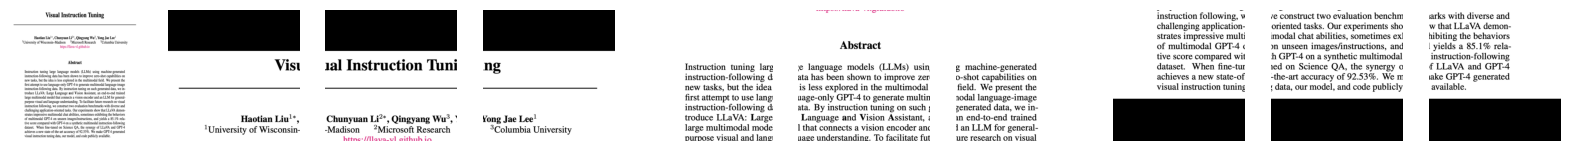

Anyres-patches embeds before unpad: 6561 ViT embeds
Anyres-patches embeds after unpad: 5103 ViT embeds
#visual tokens: 5895
#text tokens: 24
Generation time: 43.6 seconds

**Response**: <|im_start|>assistant
The image contains a document with the title "Visual Instruction Tuning" at the top. Below the title, there are names and affiliations of individuals associated with the University of Wisconsin-Madison, Microsoft Research, and Columbia University. The text is an abstract for a paper or presentation, discussing the tuning of large language models (LLMs) using machine-generated instruction-following data to improve zero-shot capabilities on new tasks. It mentions the first attempt to use language-only GPT-4 to generate multimodal language-image instruction-following data and introduces LLaVA: Large Language and Vision Assistant, an end-to-end trained large multimodal model that connects a vision encoder and an LLM for general-purpose visual and language understanding.

The abstract a

In [ ]:
prompt = '<image>\nWhat is written in the image?'
print(f'**Question**: {prompt}')


for anyres_grid_size in range(1, 4):
    response = gen_response_anyres(
        prompt,
        image,
        model,
        image_processor,
        tokenizer,
        grid_pinpoints=[[anyres_grid_size, anyres_grid_size]],

        max_new_tokens=300,
        do_sample=False,
    )

    print(f'\n**Response**: {response}\n\n')

# LaVIT

In [ ]:
!git clone https://github.com/jy0205/LaVIT.git

import sys; sys.path.append('LaVIT/LaVIT')

In [ ]:
!pip install -q diffusers==0.21.0
!pip install -q transformers==4.33.2
!pip install -q huggingface-hub==0.25.2

In [5]:
import os
import random
import torch
import torch.nn as nn
from models import build_model
from PIL import Image

seed = 1234
random.seed(seed)
torch.manual_seed(seed)

model_path = CHECKPOINTS_DIR / 'LaVIT'

# Using BFloat16 during inference
model_dtype = 'bf16'
torch_dtype = torch.bfloat16 if model_dtype=="bf16" else torch.float16

# Inference using GPU-0
device_id = 0
torch.cuda.set_device(device_id)
device = torch.device('cuda')

Please 'pip install apex'


/opt/python/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/opt/python/lib/python3.10/site-packages/timm/models/hub.py:4: FutureWarning: Importing from timm.models.hub is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [ ]:
# Building LaVIT for understanding and load its weight from huggingface
model = build_model(model_path=model_path, model_dtype=model_dtype,
                    device_id=device_id, use_xformers=False, understanding=True)

# отдельные классы моделей для режиме с генерацией визуальных токенов и без
# для text-only визуальные токены не генерируются

model = model.to(device)

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading LaVIT Model Weight from /home/jovyan/llava-training-datavol-1/checkpoints/LaVIT, model precision: bf16


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

The Visual Vocab Size is 16384
The llama tokenizer vocab size is 32000
Load eva vitG weight from /home/jovyan/llava-training-datavol-1/checkpoints/LaVIT/visual_tokenizer/eva_vitg_psz14.bin
Load visual tokenizer encoder weight from /home/jovyan/llava-training-datavol-1/checkpoints/LaVIT/visual_tokenizer/tokenizer_encoder.bin
For multi-modal understanding, Load visual tokenizer weight from /home/jovyan/llava-training-datavol-1/checkpoints/LaVIT/language_model/visual_weight.bin


### image -> text

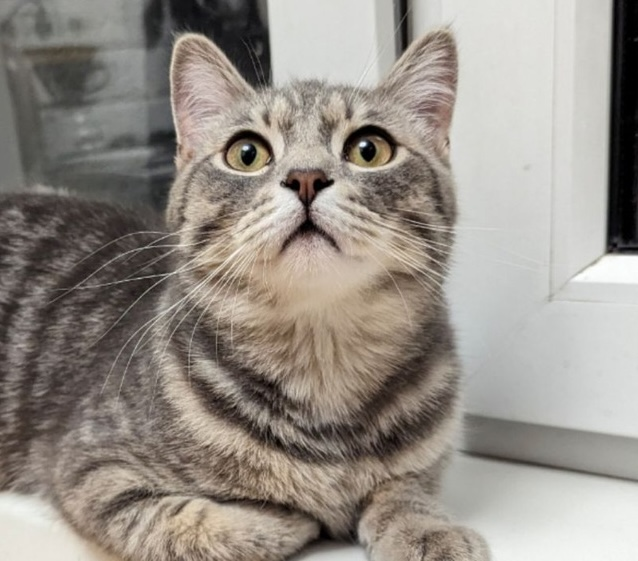

Question: What is shown in the image?
Answer: a cat


In [10]:
from IPython import display

image_path = 'images/cat.jpg'

display.display(display.Image(filename=image_path, width=200))

question = "What is shown in the image?"
print("Question:", question)
answer = model.predict_answers({"image": image_path, "text_input": question}, max_len=30, length_penalty=0)[0]
print("Answer:", answer)

In [11]:
question = "Where is the cat?"
print("Question:", question)
answer = model.predict_answers({"image": image_path, "text_input": question}, max_len=30, length_penalty=0)[0]
print("Answer:", answer)

Question: Where is the cat?
Answer: window sill


### text -> image

In [6]:
model = build_model(model_path=model_path, model_dtype=model_dtype, check_safety=False,
                    device_id=device_id, use_xformers=False, understanding=False, load_tokenizer=True)
model = model.to(device)

# check_safety: load the stable diffusion safety checker to check the safety of generated image
# load_tokenizer: visual tokenizer for passing images

/opt/python/lib/python3.10/site-packages/huggingface_hub/file_download.py:1204: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading LaVIT Model Weight from /home/jovyan/llava-training-datavol-1/checkpoints/LaVIT, model precision: bf16


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Load eva vitG weight from /home/jovyan/llava-training-datavol-1/checkpoints/LaVIT/visual_tokenizer/eva_vitg_psz14.bin
Load visual tokenizer encoder weight from /home/jovyan/llava-training-datavol-1/checkpoints/LaVIT/visual_tokenizer/tokenizer_encoder.bin
Load visual tokenizer decoder weight from /home/jovyan/llava-training-datavol-1/checkpoints/LaVIT/visual_tokenizer/highres_tokenizer_decoder.bin


In [ ]:
def gen_image(prompt, model):
    with torch.cuda.amp.autocast(enabled=True, dtype=torch_dtype):
        images = model.generate_image(prompt, width=1024, height=1024, num_return_images=1,
                                      guidance_scale_for_llm=4.0, num_inference_steps=25, top_k=50)
    return images[0]

In [ ]:
from matplotlib import pyplot as plt


def plot_pil_images(imgs):
    preview_size = (384, 384)

    fig, axes = plt.subplots(1, len(imgs), figsize=(len(imgs) * 4, 4))
    if len(imgs) == 1:
        axes = [axes]

    for ax, img in zip(axes, imgs):
        ax.imshow(img)
        ax.axis("off")

    plt.show()

def gen_several_images(num_images=3, func=gen_image, **kwargs):
    preview_size = (384, 384)

    imgs = []
    for i in range(num_images):
        img = func(**kwargs)
        imgs.append(img)

    imgs = [img.resize(preview_size) for img in imgs]

    plot_pil_images(imgs)

100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


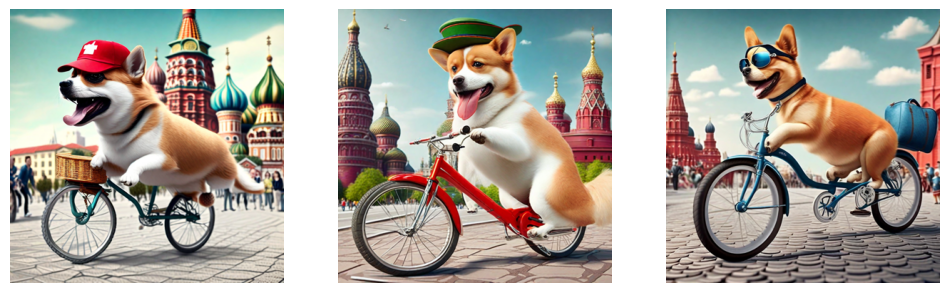

In [53]:
gen_several_images(prompt='A photo of a Corgi dog riding a bike in the Red Square, it is wearing sunglasses and a hat', model=model)

### text+image -> image

In [54]:
def gen_image_with_text(input_prompts, model):
    with torch.cuda.amp.autocast(enabled=True, dtype=torch_dtype):
        images = model.multimodal_synthesis(input_prompts, width=1024, height=1024,
                    guidance_scale_for_llm=4.0, num_return_images=1, num_inference_steps=25, top_k=50)
    return images[0]

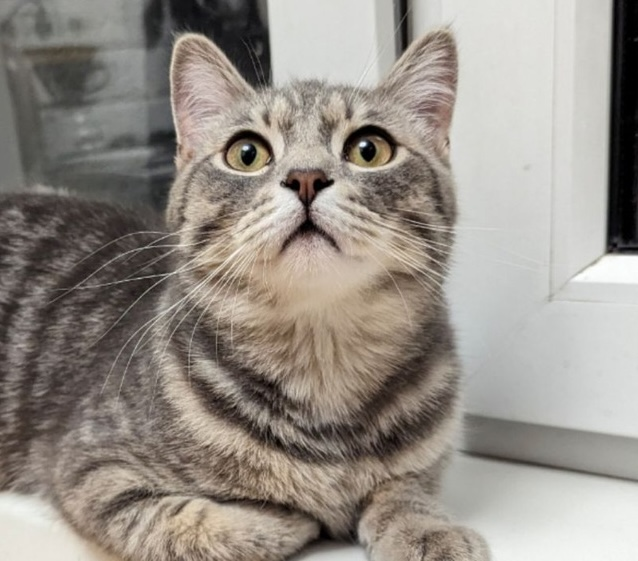

100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


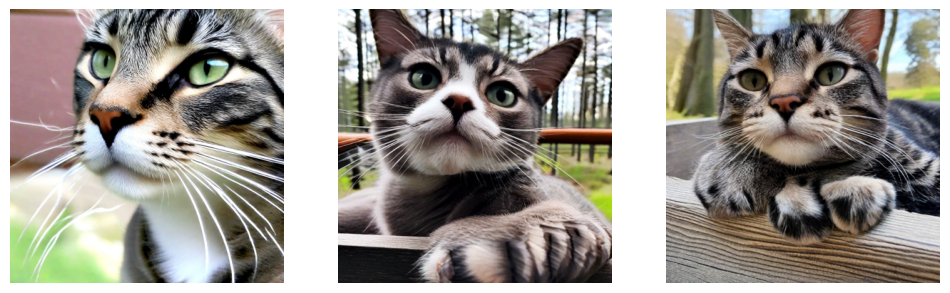

In [60]:
from IPython import display

input_prompts = [('images/cat.jpg', 'image'), ('In the forest', 'text')]
display.display(display.Image(filename='images/cat.jpg', width=200))

gen_several_images(input_prompts=input_prompts, model=model, func=gen_image_with_text)

### text+images -> image

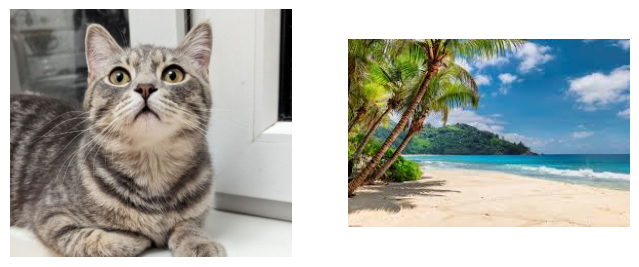

100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


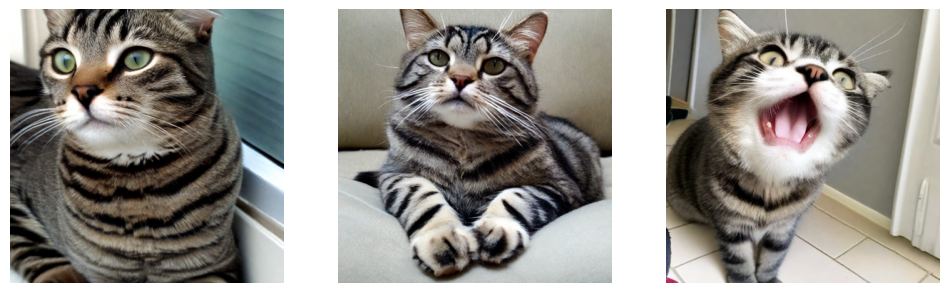

In [66]:
input_prompts = [('images/cat.jpg', 'image'), ('images/beach.jpeg', 'image')]

plot_pil_images([
    Image.open(filename)
    for filename, prompt_type in input_prompts
    if prompt_type == 'image'
])

gen_several_images(input_prompts=input_prompts, model=model, func=gen_image_with_text)

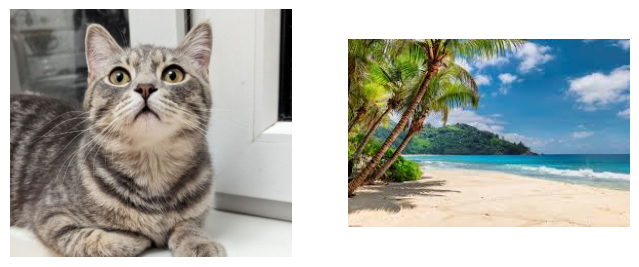

100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


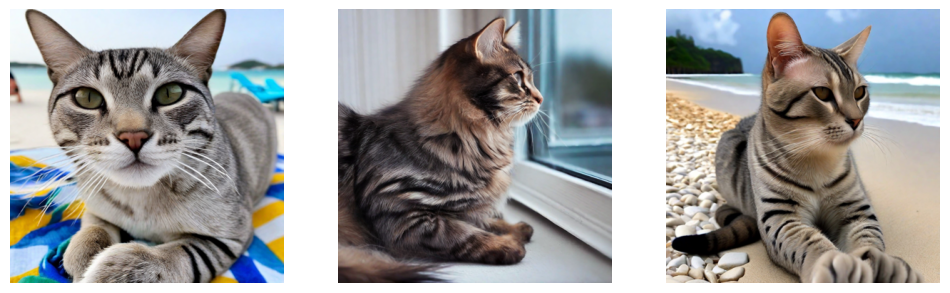

In [67]:
input_prompts = [
    ('a cat', 'text'), ('images/cat.jpg', 'image'),
    ('a beach', 'text'), ('images/beach.jpeg', 'image'),
    ('a cat on a beach', 'text')
]

plot_pil_images([
    Image.open(filename)
    for filename, prompt_type in input_prompts
    if prompt_type == 'image'
])

gen_several_images(input_prompts=input_prompts, model=model, func=gen_image_with_text)

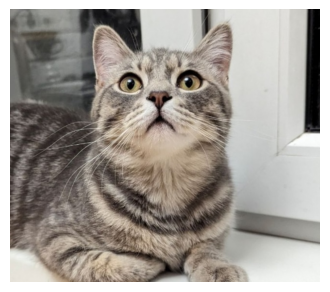

100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


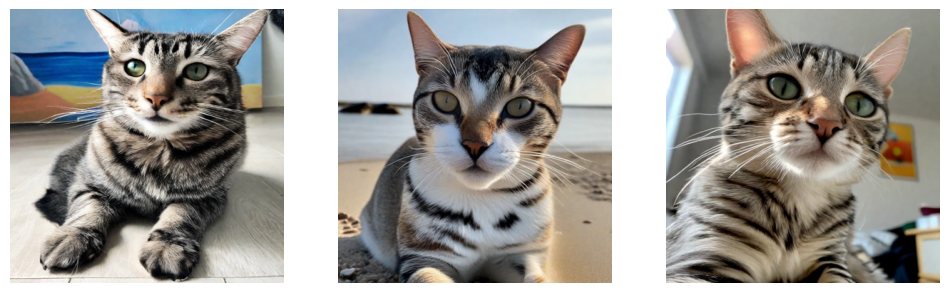

In [68]:
input_prompts = [
    ('a cat', 'text'), ('images/cat.jpg', 'image'),
    ('a cat on a beach', 'text')
]

plot_pil_images([
    Image.open(filename)
    for filename, prompt_type in input_prompts
    if prompt_type == 'image'
])

gen_several_images(input_prompts=input_prompts, model=model, func=gen_image_with_text)